# Complete run for code for Schwarzwald et al.

This code completely replicates the analysis and figures for Schwarzwald et al., _Large-scale stability and the Greater Horn of Africa long and short rains_, currently under revision. 

This notebook additionally shows alternate versions of several main text figures: 
- Replication with different reanalyis products: Figures 4-8, 12, 13
- Versions using a different reference pressure level for $h_s-h^*$: Figures 4, 5

#### To run: 
- Make sure you've updated the directory paths in `dir_list.csv` that are read by `get_params()`
- Use the included `environment_gha_stability.yml` file to create a conda environment with all necessary packages 
- If using included data: 
    - The commented out `subset_files()` calls are just there for reference - to save space in the published data, data on pressure levels outside the GHA was subset to just 650-700 hPa using this code. 

#### To try alternate setups: 
- _Alternate geographic subsets_: edit the boxes in `default_params.csv` to change which region the area-weighting for non-map figures is conducted over (for example, over which grid cells the average climatologies in Figures 4, 5, 7 are calculated). Note that, with the included data, this will only allow a smaller geographic subset than used in the paper, and that all regions will still be subset to only grid cells with a double-peaked rainy season.
- _Alternate precipitation data_: edit `mods_p` in box 2, or `mod_p` in the `wrapper_*()` functions when available. In the latter case, this will use a different precipitation dataset's seasonal statistics (which will have to be regenerated through `wrapper_seasonal_stats()`). 

#### Performance notes: 
- This code was written and tested on a server with 64GB of RAM - some functions are admittedly not optimized for low-memory operations. Keep an eye on your machine's memory usage, particularly when running `calculate_*()`. 

In [1]:
import glob
from funcs_seasstats import wrapper_seasonal_stats
from funcs_process import (calculate_h,calculate_nearsurface,
                           calculate_resampled,calculate_uq,
                           calculate_hdiff,calculate_unstable,calculate_seasmeans,
                           subset_files)
from funcs_wrapper import (wrapper_figure3,wrapper_figure4,wrapper_figure5,wrapper_figure6,
                           wrapper_figure7,wrapper_figure8,wrapper_figure9,
                           wrapper_figure1011,wrapper_figure12,wrapper_figure13)
from funcs_support import (get_params,get_subset_params)
dir_list = get_params()
subset_params_all = get_subset_params()

In [2]:
## Reanalysis data products
mods_r = ['MERRA2']
#mods_r = ['MERRA2','JRA-55','ERA5']

## Rainfall data products
mods_p = ['CHIRPS']
#mods_p = ['CHIRPS','IMERG','GPCP']

## SST data products
mods_o = ['OISST']

In [3]:
file_params = {'overwrite':False}

## Data processing

### Calculate average rainy season stats

In [4]:
wrapper_seasonal_stats({'experiment_id':'historical','time':['1981-01-01','2022-12-31'],
                        'fn_suffix':'_HoA',
                        **subset_params_all['hoa']},
                       mod_subset = mods_p,
                        **file_params)

processing model CHIRPS!
files: 
/dx01/kschwarz/project_data/gha_stability/climate_proc/CHIRPS/pr_ann_CHIRPS_historical_seasstats_dunning_19810101-20211231_HoA.nc
/dx01/kschwarz/project_data/gha_stability/climate_proc/CHIRPS/pr_doyavg_CHIRPS_historical_seasstats_dunning_19810101-20221231_HoA.nc
already exist; skipped.



In [5]:
import os; import xarray as xr
# The seasonal classification code struggles with two grid cells (out of ~ 2600) 
# in the study area (the long rains are erroneously classified as 6 months long); 
# values for them are taken from the mean of the two closest grid cells in the lat direction. 
fns = ['/dx01/kschwarz/project_data/gha_stability/climate_proc/CHIRPS/pr_doyavg_CHIRPS_historical_seasstats_dunning_19810101-20221231_HoA.nc',
       '/dx01/kschwarz/project_data/gha_stability/climate_proc/CHIRPS/pr_ann_CHIRPS_historical_seasstats_dunning_19810101-20211231_HoA.nc']
for fn in fns:
    stats = xr.open_dataset(fn)
    stats.loc[{'lon':36.125,'lat':5.375}] = stats.sel(lon=36.125,lat=[5.125,5.625]).mean('lat')
    stats.loc[{'lon':36.375,'lat':5.375}] = stats.sel(lon=36.375,lat=[5.125,5.625]).mean('lat')
    os.remove(fn)
    stats.to_netcdf(fn)
del stats

In [5]:
# Process larger area, with just annual stats, for seas_ratio for Figure 2
wrapper_seasonal_stats({'experiment_id':'historical','time':['1981-01-01','2022-12-31'],
                        'fn_suffix':'_GHA',
                        **subset_params_all['gha']},
                       proc_year = False,
                       mod_subset = mods_p,
                        **file_params)

processing model CHIRPS!
processing average seasonal statistics
/dx01/kschwarz/project_data/gha_stability/climate_proc/CHIRPS/pr_doyavg_CHIRPS_historical_seasstats_dunning_19810101-20221231_GHA.nc already exists; loaded.


### Save near-surface values

In [6]:
# Calculate near-surface humidity, temperature, circulation
for mod in mods_r: 
    calculate_nearsurface(var_list=['hus','ta','ua','va'],mod=mod,source_dir='raw',**file_params,
                          nan_search_subset = {})

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/ta-nsurf_day_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc already exists!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/ua-nsurf_day_MERRA2_historical_reanalysis_19810101-20211231_eq-EPac-Atl.nc already exists!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/ta-nsurf_day_MERRA2_historical_reanalysis_19810101-20220131_eq-WPac.nc already exists!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hus-nsurf_day_MERRA2_historical_reanalysis_19810101-20211231_subtrop-WAfr.nc already exists!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hus-nsurf_day_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc already exists!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/va-nsurf_day_MERRA2_historical_reanalysis_19810101-20211231_eq-EPac-Atl.nc already exists!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hus-nsurf_day_MERRA2_historical

In [7]:
# Now, subset the original files with all pressure levels to to 
# just a subset to make them more managable for sharing
#for mod in mods_r:
#    subset_files(mod=mod,subset={'plev':slice(700,650)},
#                 source_dir='raw',output_dir='full_files',
#                 skip_list = ['\/((ta)|(hus))\_.*HoA\.nc']) 
# Keep GHA ta, hus across all plevs to allow for analysis of HoA h_s-h^* 
# across a wider range of plevs 

/dx01/kschwarz/project_data/gha_stability/climate_raw/MERRA2/ta_day_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc already subset, moved to full_files; skipped.
/dx01/kschwarz/project_data/gha_stability/climate_raw/MERRA2/ua_day_MERRA2_historical_reanalysis_19810101-20211231_eq-EPac-Atl.nc already subset, moved to full_files; skipped.
/dx01/kschwarz/project_data/gha_stability/climate_raw/MERRA2/ta_day_MERRA2_historical_reanalysis_19810101-20220131_eq-WPac.nc already subset, moved to full_files; skipped.
/dx01/kschwarz/project_data/gha_stability/climate_raw/MERRA2/hus_day_MERRA2_historical_reanalysis_19810101-20211231_subtrop-WAfr.nc already subset, moved to full_files; skipped.
not all of plev found in ds dims (time, lat, lon), skipped.
not all of plev found in ds dims (time, lat, lon), skipped.
/dx01/kschwarz/project_data/gha_stability/climate_raw/MERRA2/hus_day_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc already subset, moved to full_files; skipped.
not all of 

In [8]:
## Do the same for 3-hourly data 
# Calculate near-surface humidity, temperature
for mod in mods_r: 
    calculate_nearsurface(var_list=['hus','ta'],
                          mod=mod,
                          freq='3hr',
                          source_dir='raw',**file_params,
                          nan_search_subset = {})
    
# Now, subset the original files with all pressure levels to to 
# just a subset to make them more managable for sharing
#for mod in mods_r:
#    subset_files(mod=mod,subset={'plev':slice(700,650)},
#                 freq='3hr',
#                 source_dir='raw',output_dir='full_files')

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/ta-nsurf_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hus-nsurf_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists!
/dx01/kschwarz/project_data/gha_stability/climate_raw/MERRA2/ta_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already subset, moved to full_files; skipped.
/dx01/kschwarz/project_data/gha_stability/climate_raw/MERRA2/hus_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already subset, moved to full_files; skipped.


### Calculate $h$, $h^*$, $h_s-h^*$

In [9]:
for mod in mods_r:
    for varname_add,source_dir in zip(['','-nsurf'],['raw','proc']):
        # Calculate h = c_pT + L_vq + gz
        calculate_h(mod=mod,varname_add=varname_add,source_dir=source_dir,**file_params)

    # Calculate hdiff = h_s-h^*
    calculate_hdiff(mod=mod,**file_params)


--------------------------
processing files of the form: "*HoA.nc"!
all files:
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_day_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/h_day_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/qsat_day_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
already exist!

--------------------------
processing files of the form: "*eq-Atl.nc"!
all files:
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_day_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/h_day_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/qsat_day_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc
already exist!

--------------------------
processi

In [10]:
# Do the same for 3-hourly day
for mod in mods_r:
    for varname_add,source_dir in zip(['','-nsurf'],['raw','proc']):
        # Calculate h = c_pT + L_vq + gz
        calculate_h(mod=mod,freq='3hr',varname_add=varname_add,source_dir=source_dir,**file_params)
        
    # Calculate hdiff = h_s-h^*
    calculate_hdiff(mod=mod,freq='3hr',**file_params)


--------------------------
processing files of the form: "*HoA.nc"!
all files:
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/h_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/qsat_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
already exist!

--------------------------
processing files of the form: "*HoA.nc"!
all files:
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat-nsurf_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/h-nsurf_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/qsat-nsurf_3hr_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
already exist!

--------------------------
pr

### Calculate max daily $h_s-h^*$ from 3-hourly data

In [11]:
# For Figure S6
for mod in mods_r:
    calculate_resampled(var='hdiff',freq='3hr',resample = {'time':'1D'},
                        func='max',search_str = '*_HoA.nc',**file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hdiffmax_day_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc saved!


### Calculate $unstable$
Boolean of when $h_s-h^*>0$ locally, to be used in seasonal average calculations.

In [12]:
for mod in mods_r:
    calculate_unstable(mod=mod,
                       var = 'hdiff',
                       search_str = '*HoA.nc',**file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/unstable_day_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists!


### Calculate $\vec{u}q$

In [13]:
for mod in mods_r: 
    calculate_uq(mod=mod)


--------------------------
processing files of the form: "*HoA.nc" in directory raw with variables *!
all files:
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/uq_day_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/vq_day_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc
already exist!

--------------------------
processing files of the form: "*eq-IO.nc" in directory raw with variables *!
all files:
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/uq_day_MERRA2_historical_reanalysis_19810101-20211231_eq-IO.nc
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/vq_day_MERRA2_historical_reanalysis_19810101-20211231_eq-IO.nc
already exist!

--------------------------
processing files of the form: "*subtrop-AfrSAsia.nc" in directory raw with variables *!
all files:
   /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/uq_day_MERRA2_historical_reanalysis_1981

### Calculate seasonal averages
Seasonal averages of: 

- $h_s-h^*$ and components, including fraction unstable
- $\vec{u}$, $\vec{u}q$

In [14]:
# Variables where we only need Horn of Africa averages and/or need both full means and anomaly means
for mod in mods_r: 
    for var in ['ta-nsurf','hus-nsurf','h-nsurf','hdiff','hsat','unstable']:
        # Calculate seasonal means 
        calculate_seasmeans(mod = mod,var=var,search_dir = 'proc',
                            suffixes = ['HoA.nc'],
                            **file_params)
        
        # Calculate seasonal means of anomalies vs. annual avg.  
        calculate_seasmeans(mod = mod,var=var,search_dir = 'proc',
                            anomaly='clim',
                            suffixes = ['HoA.nc'],
                            **file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/ta-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/ta-nsurf-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hus-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hus-nsurf-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/h-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/h-nsurf-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stabi

In [15]:
# Variables which are averaged over all geographic subsets 
# (and only anomalies are graphed)
for mod in mods_r:
    for var,source_dir in zip(['hdiff','hsat','h-nsurf','uq-nsurf','vq-nsurf','ua-nsurf','va-nsurf','ua','va'],
                              [*['proc']*7,*['raw']*2]):
        # Calculate seasonal means of anomalies vs. annual avg.  
        calculate_seasmeans(mod = mod,var=var,search_dir = source_dir,
                            anomaly='clim',
                            **file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hdiff-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hdiff-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-IO.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hdiff-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hdiff-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_subtrop-AfrSAsia.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hdiff-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-EPac.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hdiff-anom_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-WPac.nc already exists, skipped!
/dx01/kschwarz

In [16]:
# Circulation raw means 
for mod in mods_r:
    for var,source_dir in zip(['uq-nsurf','vq-nsurf','ua-nsurf','va-nsurf'],
                              [*['proc']*2,*['proc']*2]):
        # Calculate seasonal means of anomalies vs. annual avg.  
        calculate_seasmeans(mod = mod,var=var,search_dir = source_dir,
                            **file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/uq-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/uq-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-IO.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/uq-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_subtrop-AfrSAsia.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/vq-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/vq-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-IO.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/vq-nsurf_seasavg_MERRA2_historical_reanalysis_19810101-20211231_subtrop-AfrSAsia.nc already exists, skipped!
/dx01/kschwarz/project

In [17]:
# h* for Figure S7
for mod in mods_r:
    # Calculate seasonal means of anomalies vs. annual avg.  
    calculate_seasmeans(mod = mod,var='hsat',search_dir = 'proc',
                            **file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-IO.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_seasavg_MERRA2_historical_reanalysis_19810101-20211231_subtrop-AfrSAsia.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-EPac.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_seasavg_MERRA2_historical_reanalysis_19810101-20211231_eq-WPac.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_

In [18]:
# Seasonal average rainfall for rainfall products
for mod in mods_p:
    calculate_seasmeans(mod = mod,var='pr',search_dir = 'raw',
                        suffixes = ['GHA.nc'],suffix_out = 'HoA.nc',
                        subset_params_load = subset_params_all['hoa_slice'],
                                **file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/CHIRPS/pr_seasavg_CHIRPS_historical_obs_19810101-20211231_HoA.nc already exists, skipped!


In [19]:
# Seasonal average rainfall for reanalysis
for mod in mods_r:
    calculate_seasmeans(mod = mod,var='pr',search_dir = 'raw',
                        suffixes = 'HoA.nc',
                    subset_params_load = subset_params_all['hoa_slice'],
                            **file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/pr_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!


In [20]:
# Seasonal average SSTs
for mod in mods_o:
    calculate_seasmeans(mod = mod,var='tos',search_dir = 'raw',
                        calculate_local=False,
                            **file_params)

/dx01/kschwarz/project_data/gha_stability/climate_proc/OISST/tos_seasavg_OISST_historical_avhrr_19810901-20211231_NCIndOcean.nc already exists, skipped!


In [21]:
# h_s-h*, unstable, P for Figure S9
for mod in mods_r:
    for var in ['hdiff','unstable']:
        # Calculate seasonal means of anomalies vs. annual avg.  
        calculate_seasmeans(mod = mod,var=var,search_dir = 'proc',
                            suffixes = ['HoA.nc'],
                                **file_params)
        
for mod in [mod for mod in mods_p if mod != 'CHIRPS']:
    # Calculate seasonal means of anomalies vs. annual avg.  
    calculate_seasmeans(mod = mod,var='pr',search_dir = 'raw',
                                **file_params)
        

/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hdiff_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!
/dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/unstable_seasavg_MERRA2_historical_reanalysis_19810101-20211231_HoA.nc already exists, skipped!


## Numbers

In [22]:
# Section 4a, statement on how many grid-cell-days 
# are outside of the [-25, 5] kJ/kg range
def numbers_pctunstable_range(mod='MERRA2',plev=650,
                              vrange = [-25000,5000]):
    from funcs_support import subset_to_srat
    from funcs_load import load_raw
    import numpy as np
    
    # Load h_s-h^* and subset to double-peaked region
    ds = subset_to_srat(load_raw('hdiff_day*HoA.nc',search_dir=dir_list['proc']+mod+'/',
                        subset_params = {'plev':[plev]}))
    
    # Count grid cell days within range 
    pct = (((ds.hdiff>vrange[0]) & (ds.hdiff<vrange[1])).sum(('lat','lon','time')) / 
            (~np.isnan(ds.hdiff)).sum(('lat','lon','time'))*100)
    print('% of grid-cell-days in Figure 3 between '+str(vrange[0]/1000)+' and '+str(vrange[1]/1000)+' kJ/kg: '+
          str(np.round(pct,2).values))

numbers_pctunstable_range()

% of grid-cell-days in Figure 3 between -25.0 and 5.0 kJ/kg: 99.7


In [23]:
# Section 5b, statement on the average hs anomalies
def numbers_hsanomalies(mod='MERRA2',plev=650,
                        kind='dunning_local',season='long_rains'):
    from funcs_load import load_raw
    from funcs_support import subset_to_srat,area_mean
    import re
    import numpy as np
    
    # Load seasonal means of near-surface h anomalies
    ds = subset_to_srat(load_raw('h-nsurf-anom_seasavg_*HoA.nc',
              search_dir = dir_list['proc']+mod+'/'))
    
    # Get average anomaly for a given season, averaging type
    anom = area_mean(ds.sel(kind=kind,season=season)).mean('year').h 
    print('Mean hs anomaly during the '+re.sub('\_',' ',season)+' season: '+
          str(np.round(anom/1000,2).values)+' kJ/kg')

numbers_hsanomalies(season='long_rains')
numbers_hsanomalies(season='short_rains')


Mean hs anomaly during the long rains season: 5.31 kJ/kg
Mean hs anomaly during the short rains season: 2.54 kJ/kg


In [24]:
# Section 7, the impact of a 1kJ/kg increase in h_s-h^*
def numbers_hdiffincrease(mod='MERRA2',mod_p='CHIRPS',
                          season='long_rains',
                          shift = 1000,
                          plev=650):
    from funcs_load import load_raw
    from funcs_support import subset_to_srat,area_mean,area_grid
    import numpy as np
    import xesmf as xe
    import warnings
    
    # Load h_s-h^*
    ds = load_raw('hdiff_day*HoA.nc',
              search_dir = dir_list['proc']+mod+'/').sel(plev=plev,drop=True)
    
    # Load booleans of seasonal belonging
    sidxs = load_raw('seasidxs*HoA.nc',
                 search_dir = dir_list['proc']+mod_p+'/').sel(season=season,drop=True)

    # Regrid hdiff to precip/seas idxs grid (as is done in 
    # Figure 3 - regridding seas idxs to hdiff instead only
    # marginally changes numbers, O(1%))
    rgrd = xe.Regridder(ds,sidxs,method='bilinear')
    with warnings.catch_warnings():
        # Ignore the FutureWarning that shows up from inside xesmf 
        # and adds nothing to the conversation
        warnings.simplefilter('ignore') 
        ds = rgrd(ds)
    
    # Make sure NaNs stay NaNs (by setting pixels that were never
    # assigned to a season to NaN)
    ds = ds.where(ds!=0)
    
    # Subset to double-peaked region
    ds = subset_to_srat(ds)
   
    # Subset to just desired season
    ds = ds.where(sidxs.ts.astype(bool)).hdiff
    
    # Get area of each grid cell
    weights = area_grid(ds.lat,ds.lon)
    
    # Get how many non-nan pixels there are in total
    npixs = ((~np.isnan(ds))*weights).sum()
    
    # Get number of grid-cell-days with h_s-h^*>0
    npos = ((ds>0)*weights).sum()
    
    # Get number of grid-cell-days with h_s-h^*>0 with a
    # uniform increase of h_s-h^* of 1 kJ/kg
    npos1000 = (((ds+shift)>0)*weights).sum()
    
    print('Increasing hs-h^* by '+str(shift/1000)+' kJ/kg increases the proportion of unstable grid cell days from '+
          str(np.round((npos/npixs).values*100))+'% to '+str(np.round((npos1000/npixs).values*100))+'%')

numbers_hdiffincrease()

Increasing hs-h^* by 1.0 kJ/kg increases the proportion of unstable grid cell days from 42.0% to 60.0%


## Figures

### Figure 1: GHA mean rainfall in a global / zonal context

/home/kschwarz/projects/gha_stability/figures/figure1.png saved!
/home/kschwarz/projects/gha_stability/figures/figure1.pdf saved!


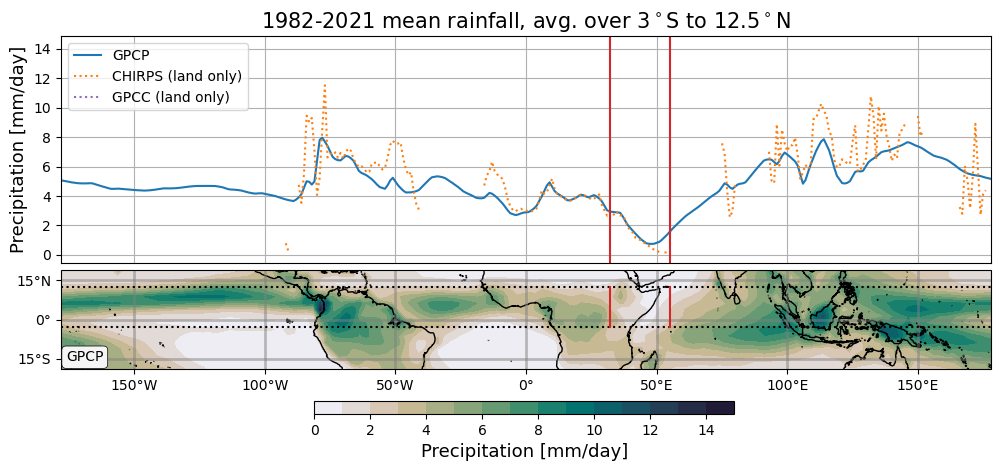

In [25]:
# See `plot_figure1.py`
%run plot_figure1.py

### Figure 2: GHA study area

/home/kschwarz/projects/gha_stability/figures/figure2.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure2.png saved!


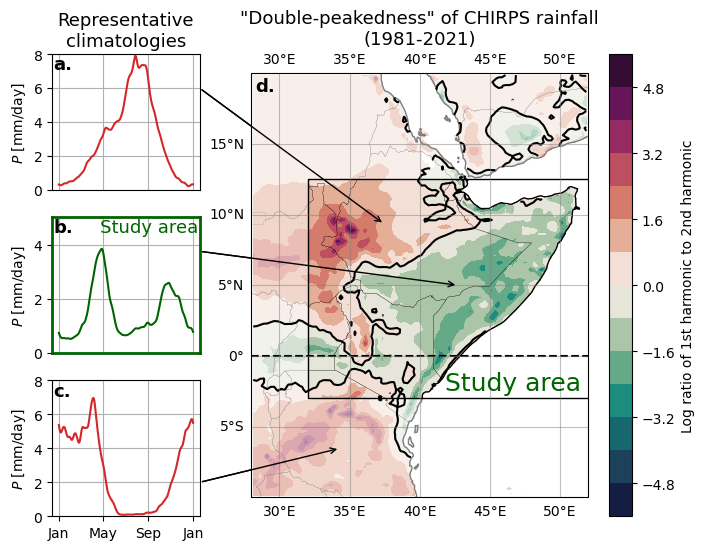

In [26]:
# See `plot_figure2.py`
%run plot_figure2.py

### Figure 3 and S5-S6: Boxplots and Histograms

calculating or loading seasonal booleans...
plotting...
/home/kschwarz/projects/gha_stability/figures/figure3.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure3.png saved!


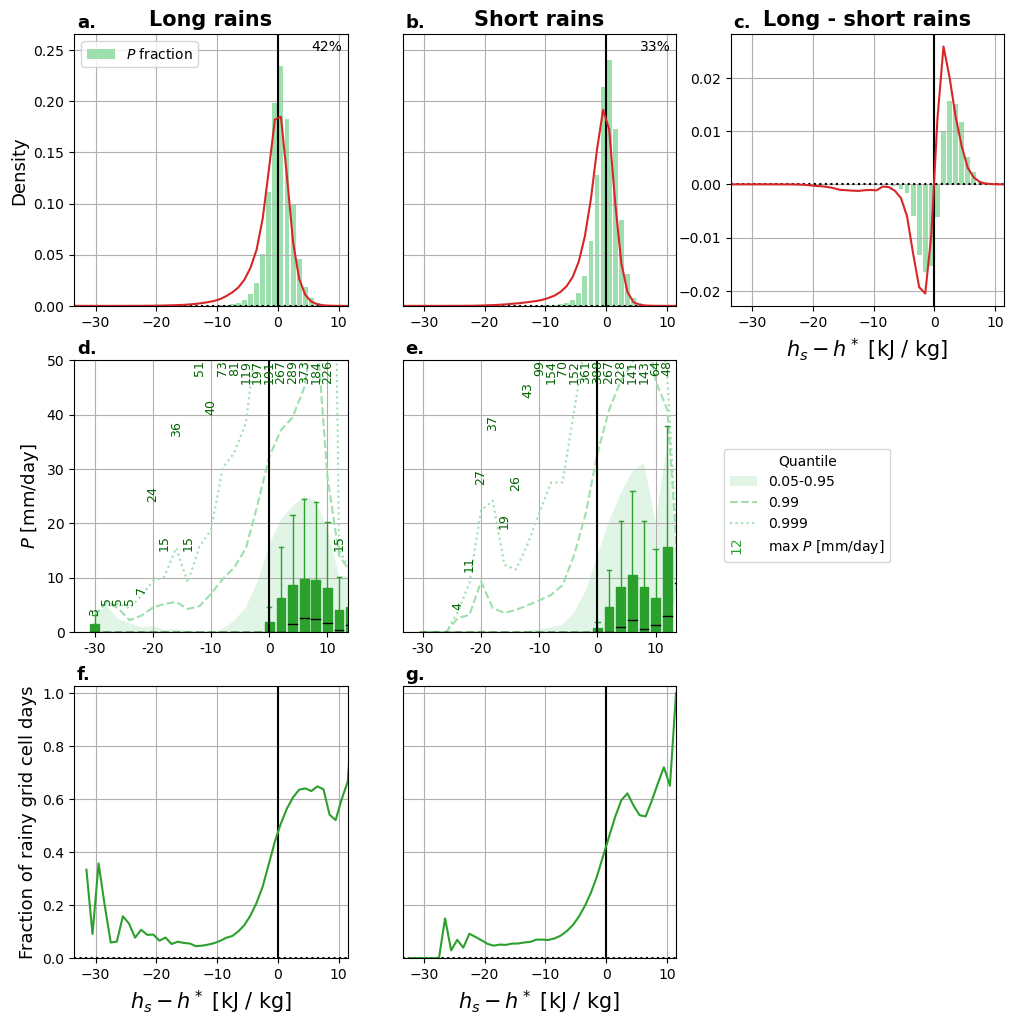

In [27]:
wrapper_figure3(save_fig=True,subset_params = subset_params_all['hoa_slice'],
                output_fn=dir_list['figs']+'figure3')

#### Alternate versions

calculating or loading seasonal booleans...
plotting...
/home/kschwarz/projects/gha_stability/figures/figure_s5.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure_s5.png saved!


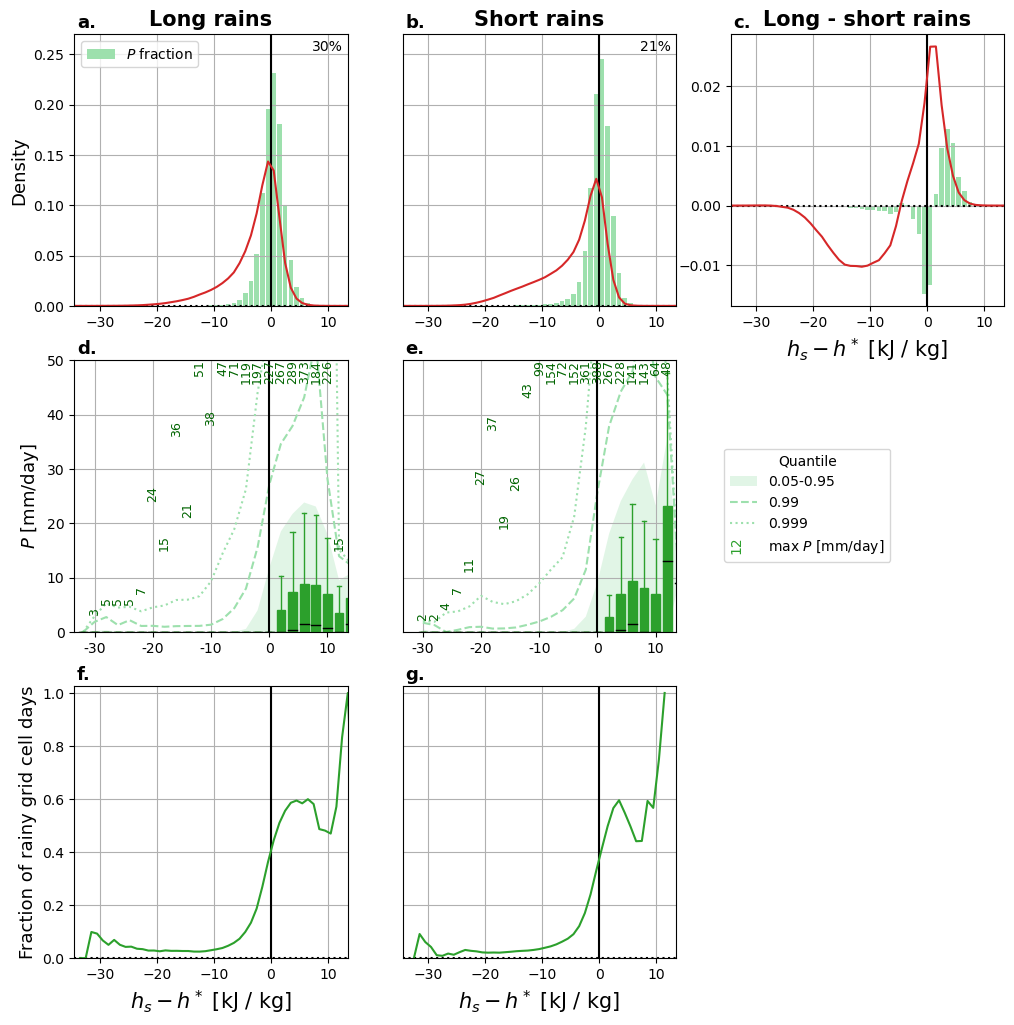

In [28]:
wrapper_figure3(kind='month',save_fig=True,output_fn=dir_list['figs']+'figure_s5')

calculating or loading seasonal booleans...
plotting...
/home/kschwarz/projects/gha_stability/figures/figure_s6.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure_s6.png saved!


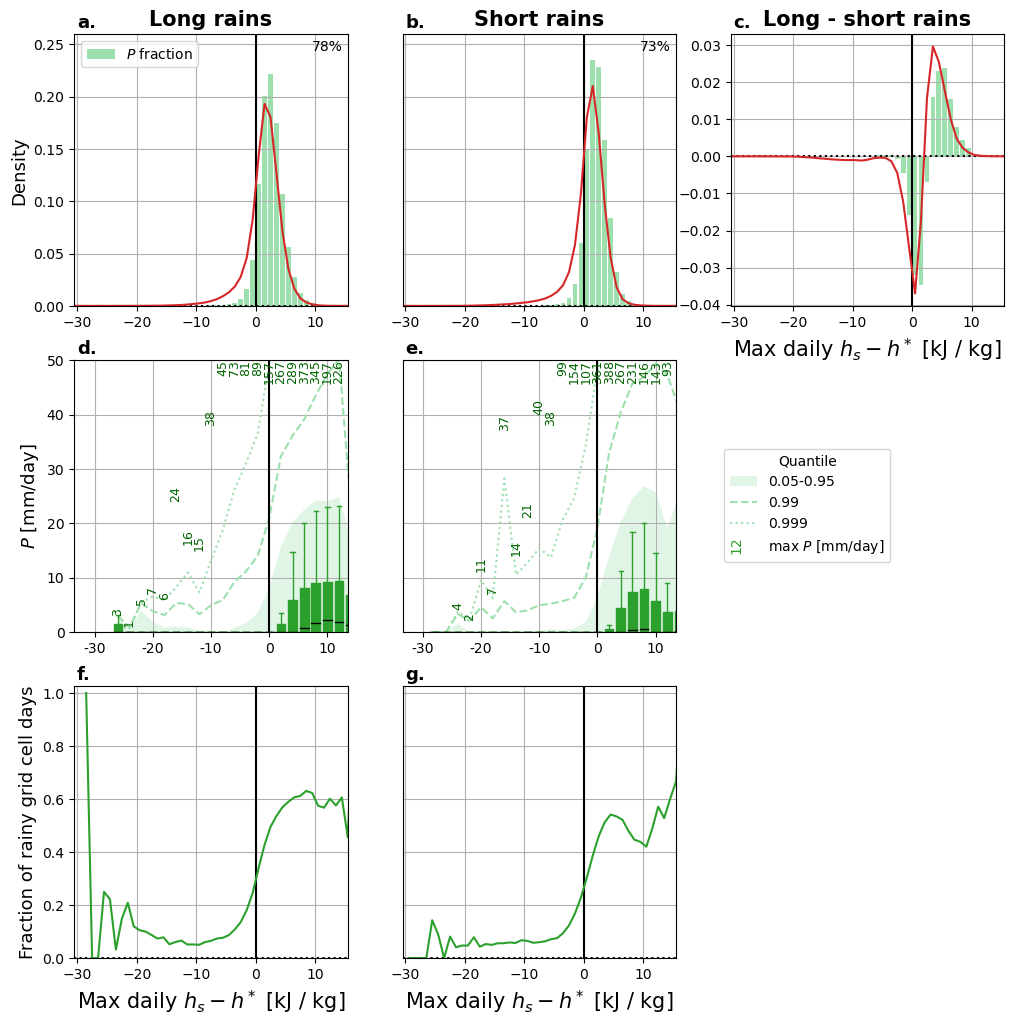

In [29]:
wrapper_figure3(var='hdiffmax',save_fig=True,output_fn=dir_list['figs']+'figure_s6')

### Figure 4: Seasonal cycle of % of grid cells unstable

/home/kschwarz/projects/gha_stability/figures/figure4.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure4.png saved!


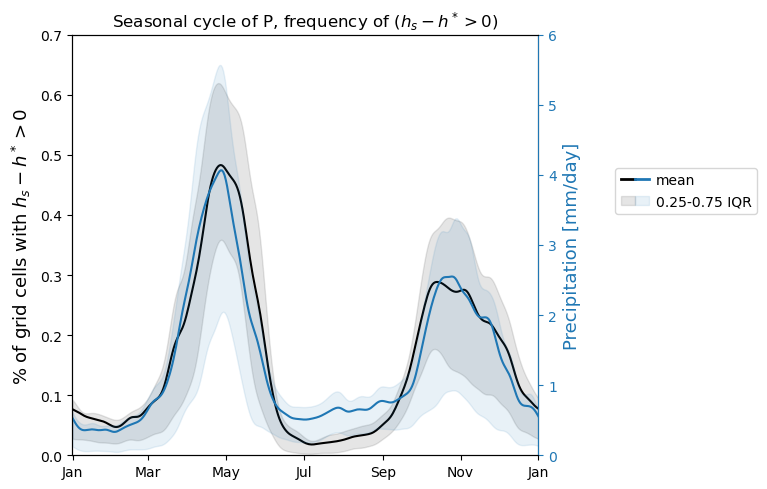

In [30]:
wrapper_figure4(mod_h='MERRA2',save_fig=True,output_fn=dir_list['figs']+'figure4',
                subset_params = subset_params_all['hoa_slice'])

#### Alternate versions

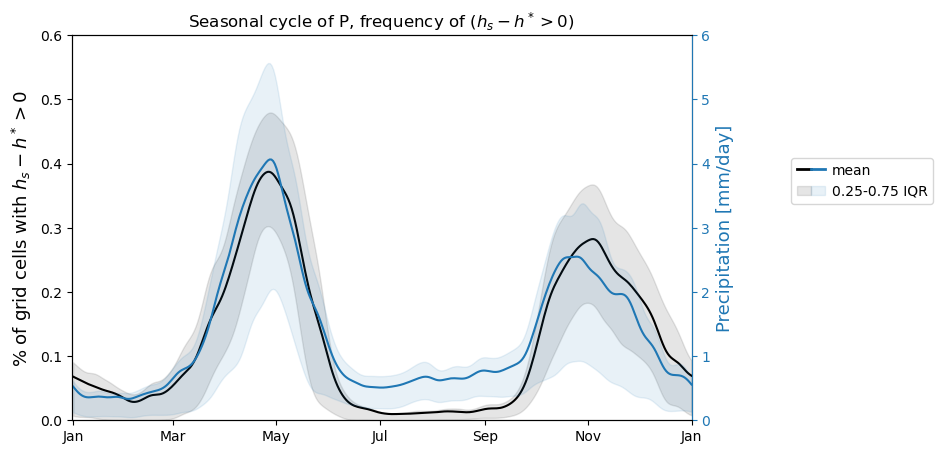

In [31]:
wrapper_figure4(mod_h='MERRA2',save_fig=False,plev=700,
                ylims = [[0,0.6],[0,6]])

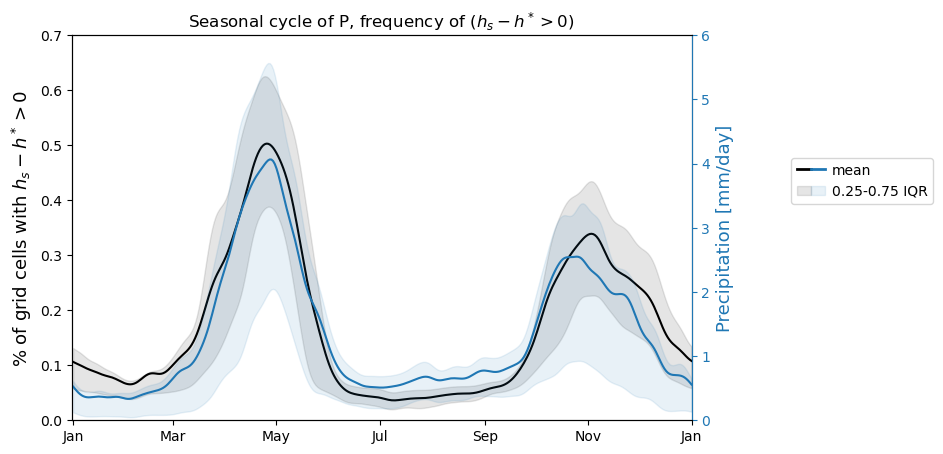

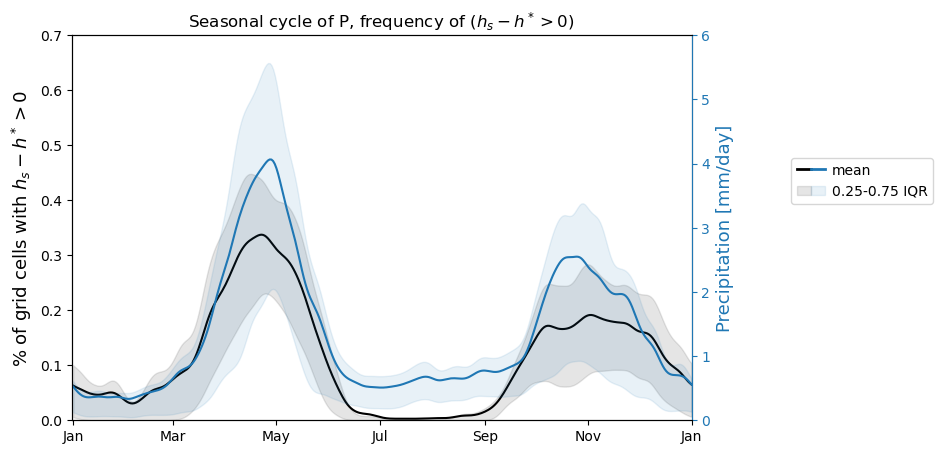

In [32]:
for mod in ['ERA5','JRA-55']:
    wrapper_figure4(mod_h=mod,plev=650,ylims = [[0,0.7],[0,6]])

### Figure 5: Seasonal cycle of $h_s-h^*$, $P$, and $h_s-h^*$ component anomalies

/home/kschwarz/projects/gha_stability/figures/figure5.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure5.png saved!


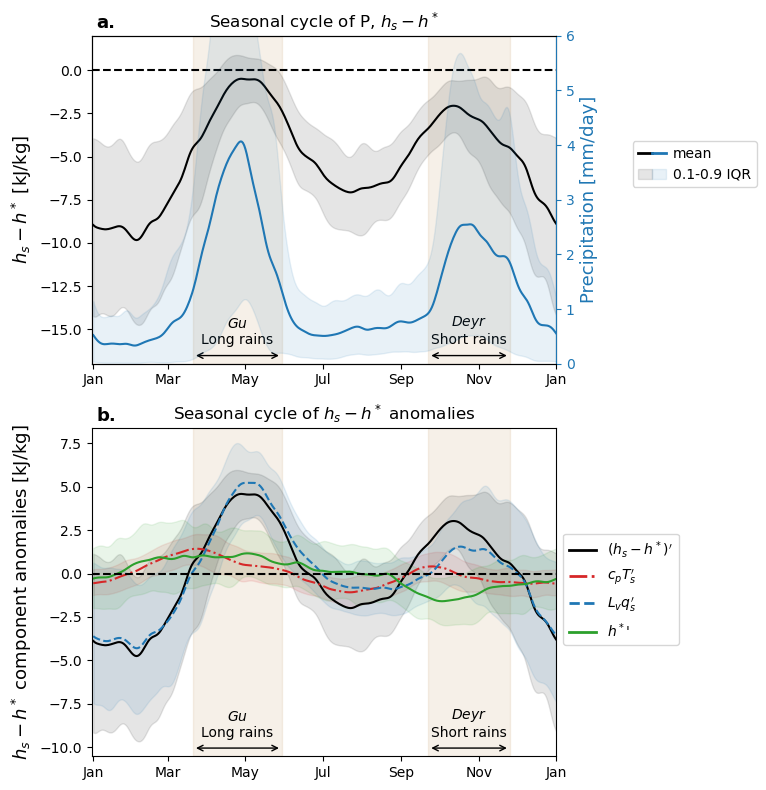

In [33]:
wrapper_figure5(mod_h = 'MERRA2',save_fig=True,output_fn=dir_list['figs']+'figure5')

#### Alternate versions

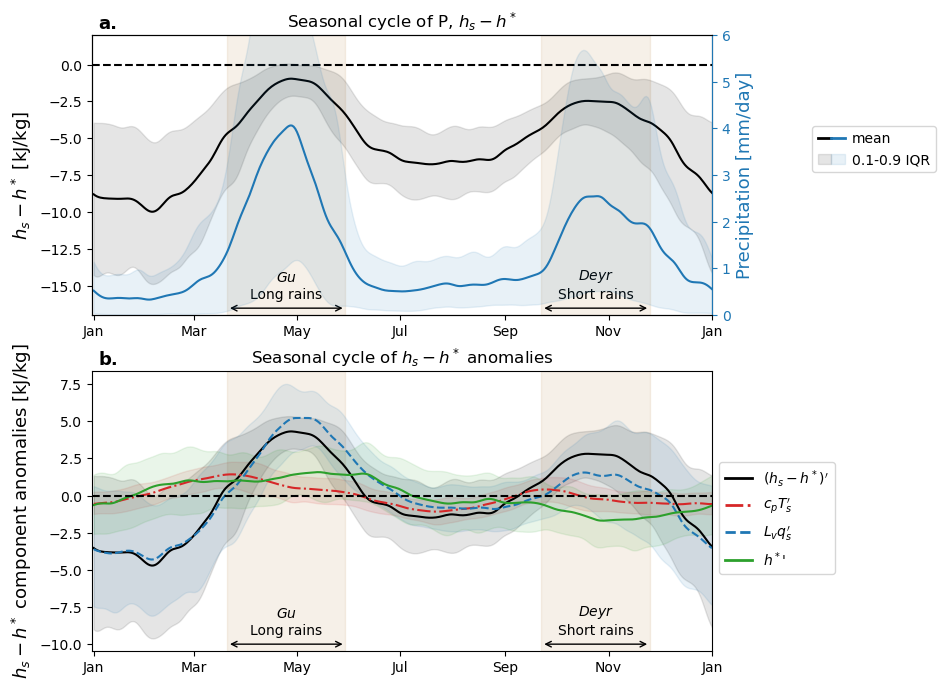

In [34]:
wrapper_figure5(mod_h = 'MERRA2',save_fig=False,
                plev=700)

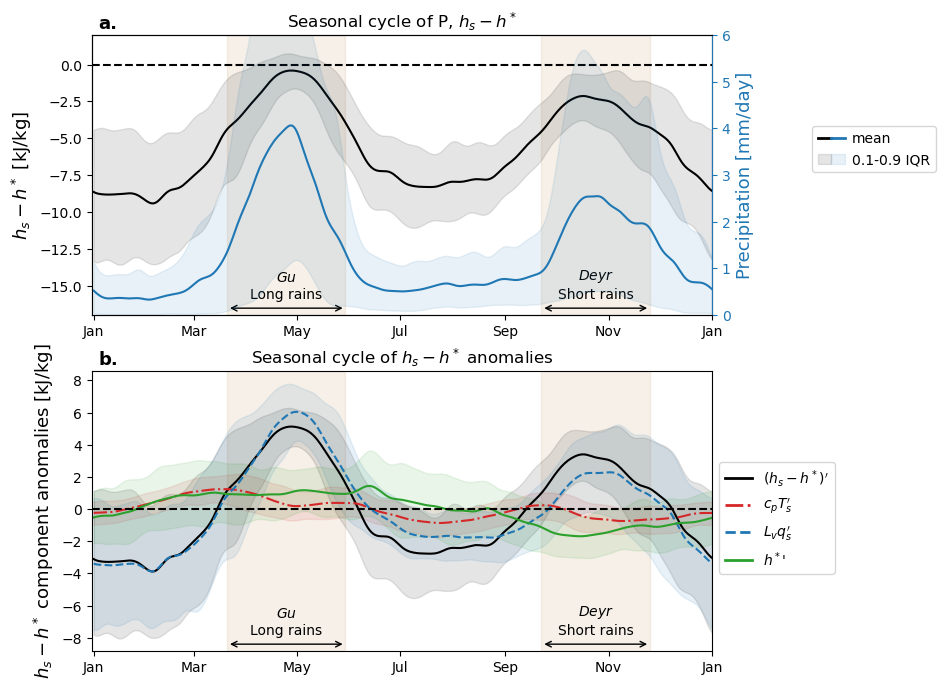

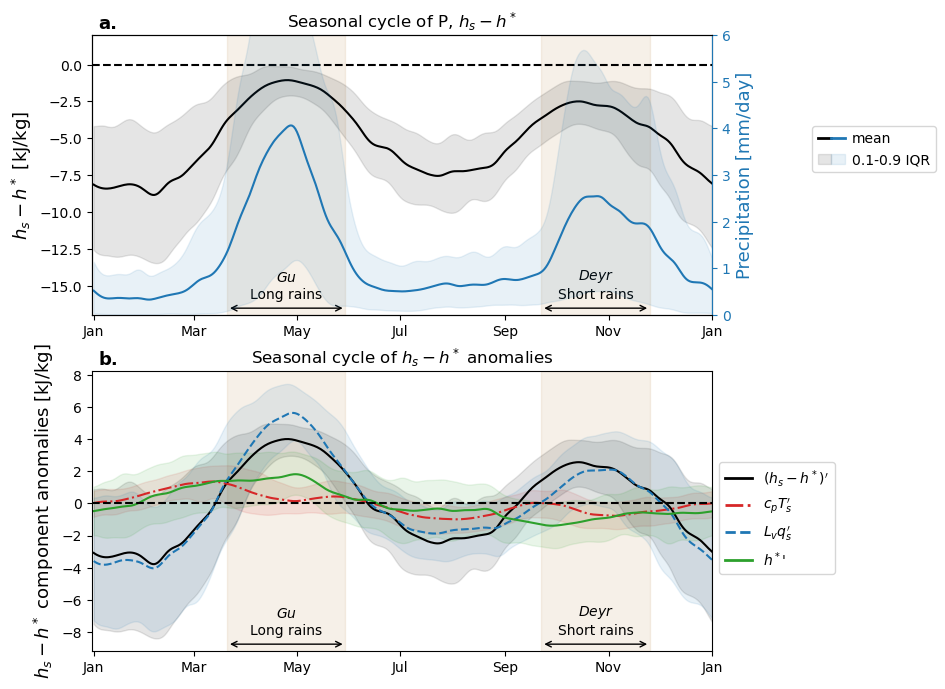

In [35]:
for mod in ['ERA5','JRA-55']:
    wrapper_figure5(mod_h = mod,save_fig=False)

### Figure 6: $P$ vs. $h_s-h^*$

/home/kschwarz/projects/gha_stability/figures/figure6.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure6.png saved!


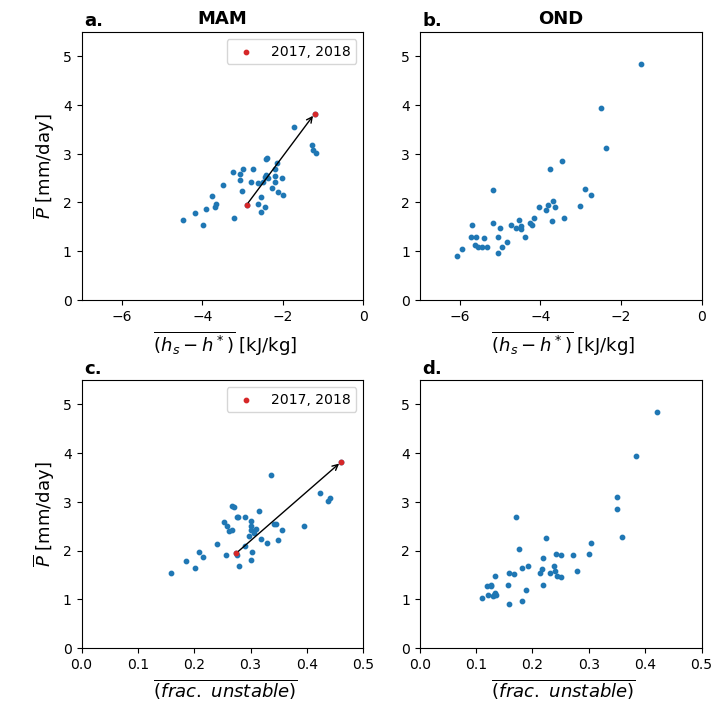

In [36]:
wrapper_figure6(save_fig=True,subset_params = subset_params_all['hoa_slice'],
                output_fn=dir_list['figs']+'figure6')

#### Alternate versions

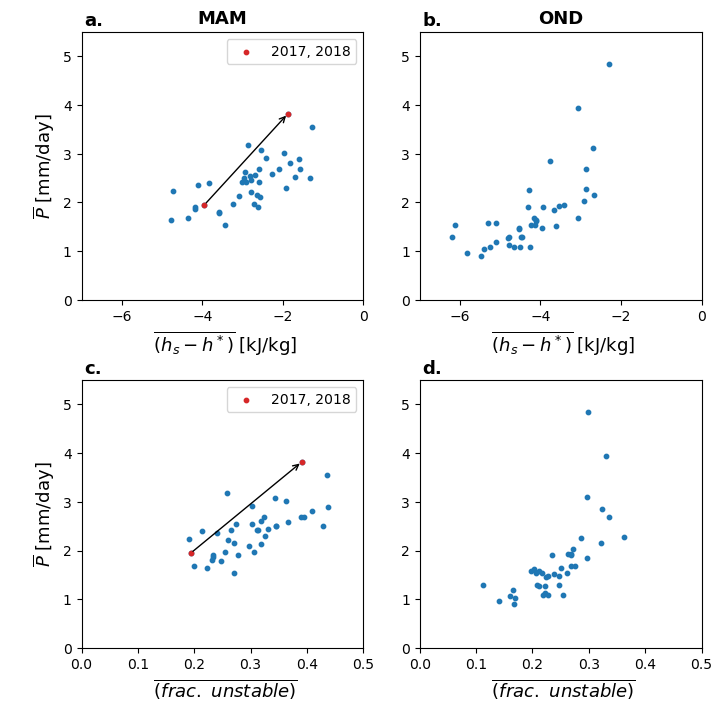

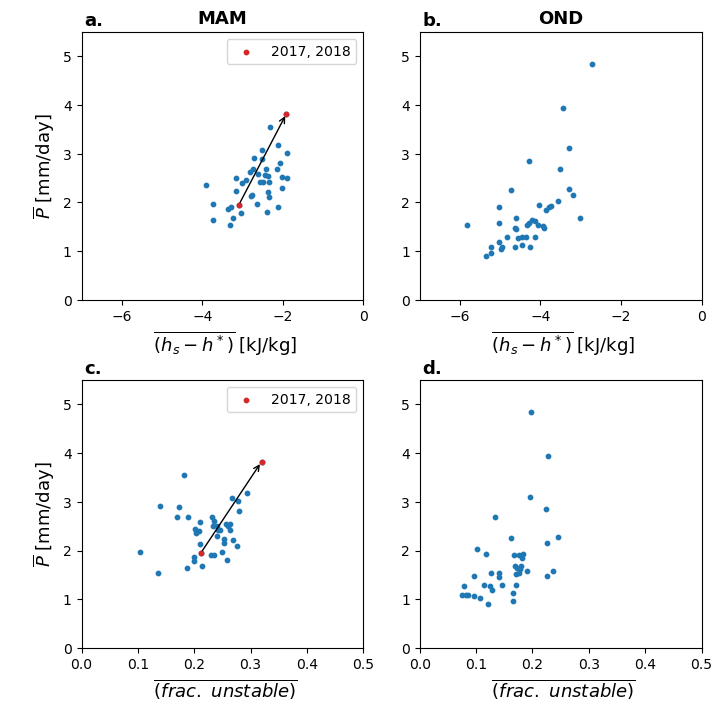

In [37]:
for mod in ['ERA5','JRA-55']:
    wrapper_figure6(mod_a = mod,subset_params = subset_params_all['hoa_slice'],save_fig=False)

### Figure 7: Temperature and radiation climatologies

/home/kschwarz/projects/gha_stability/figures/figure7.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure7.png saved!


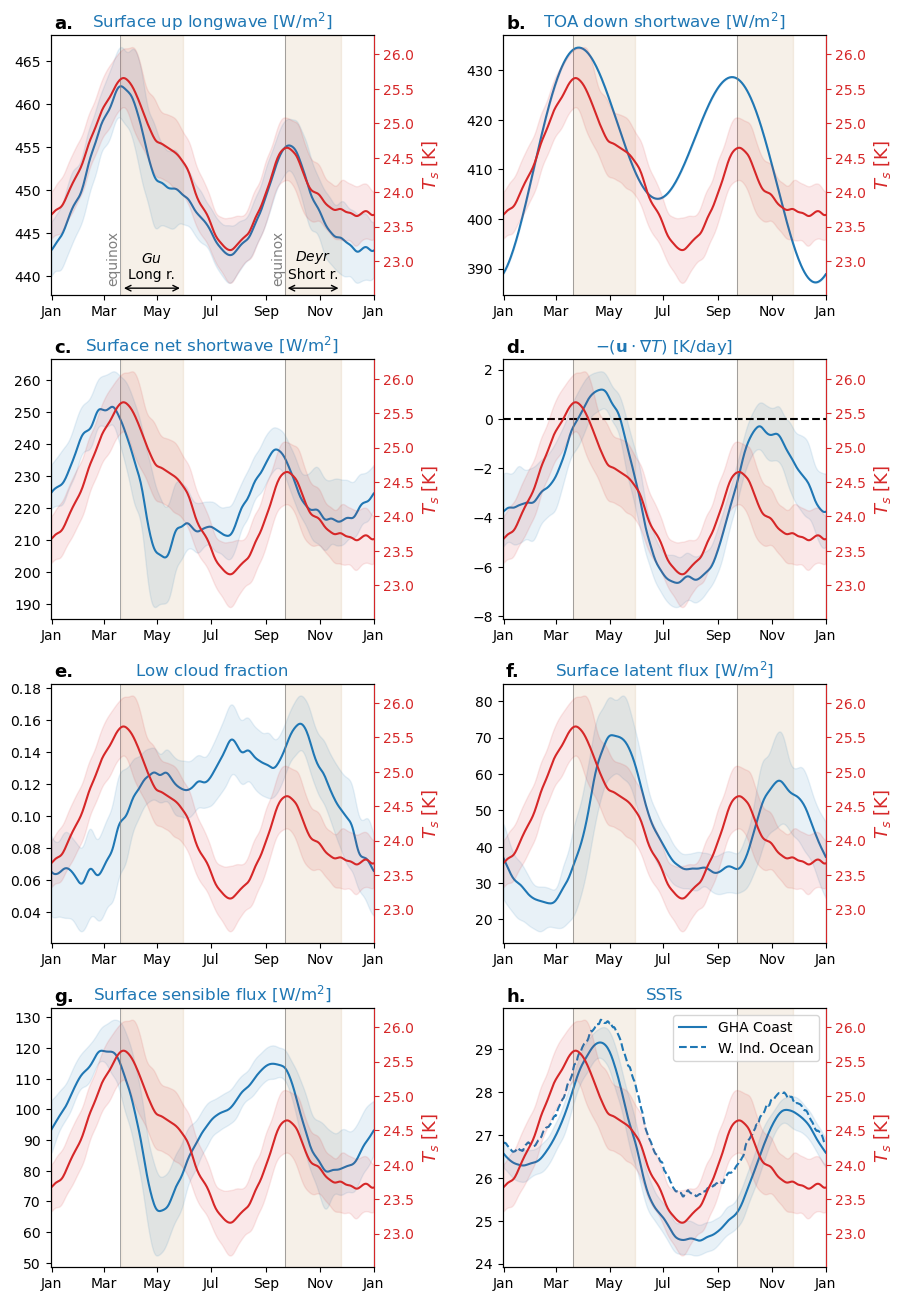

In [38]:
wrapper_figure7(save_fig=True,output_fn=dir_list['figs']+'figure7')

### Figure 8: Interannual variability in $h_s-h^*$ components

/home/kschwarz/projects/gha_stability/figures/figure8.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure8.png saved!


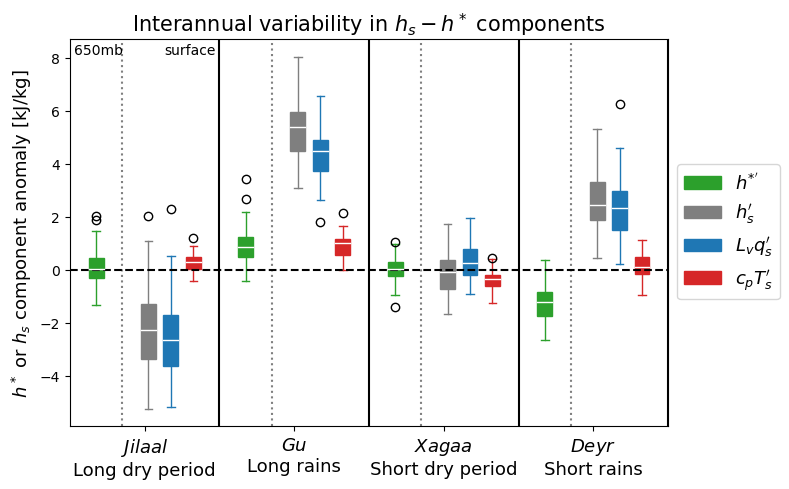

In [39]:
wrapper_figure8(mod='MERRA2',save_fig=True,output_fn=dir_list['figs']+'figure8')

#### Alternate versions

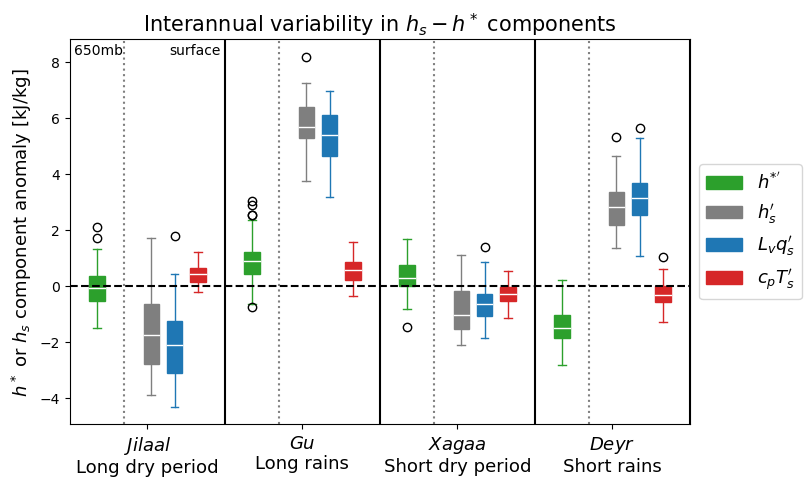

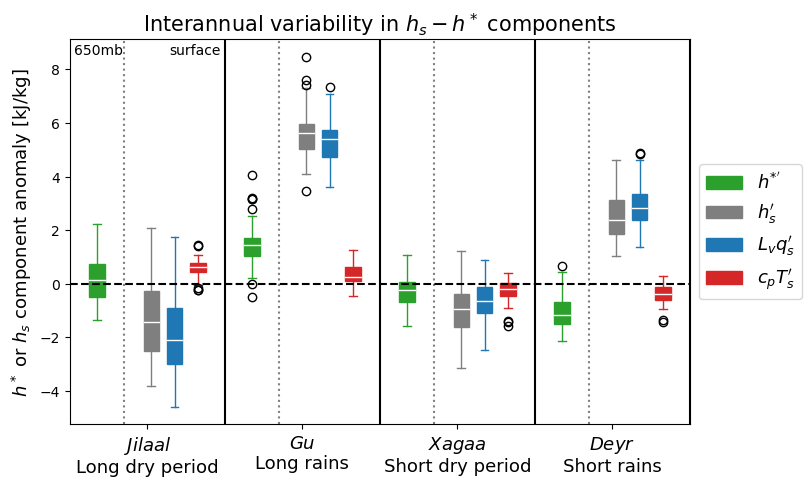

In [40]:
for mod in ['ERA5','JRA-55']:
    wrapper_figure8(mod=mod,save_fig=False)

### Figure 9: $\vec{u}$ and $\vec{u}q_s$

/home/kschwarz/projects/gha_stability/figures/figure9.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure9.png saved!


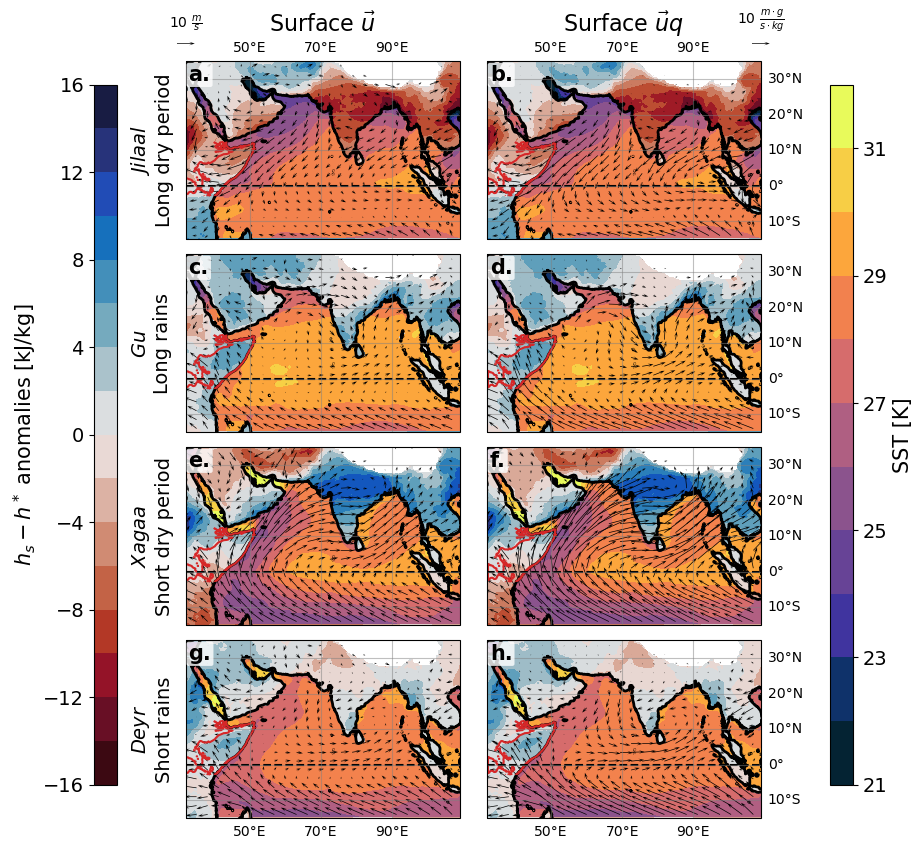

In [41]:
wrapper_figure9(save_fig=True,output_fn=dir_list['figs']+'figure9')

### Figures 10 - 11: $h_s$ and $h^*$ anomaly maps

/home/kschwarz/projects/gha_stability/figures/figure10.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure10.png saved!


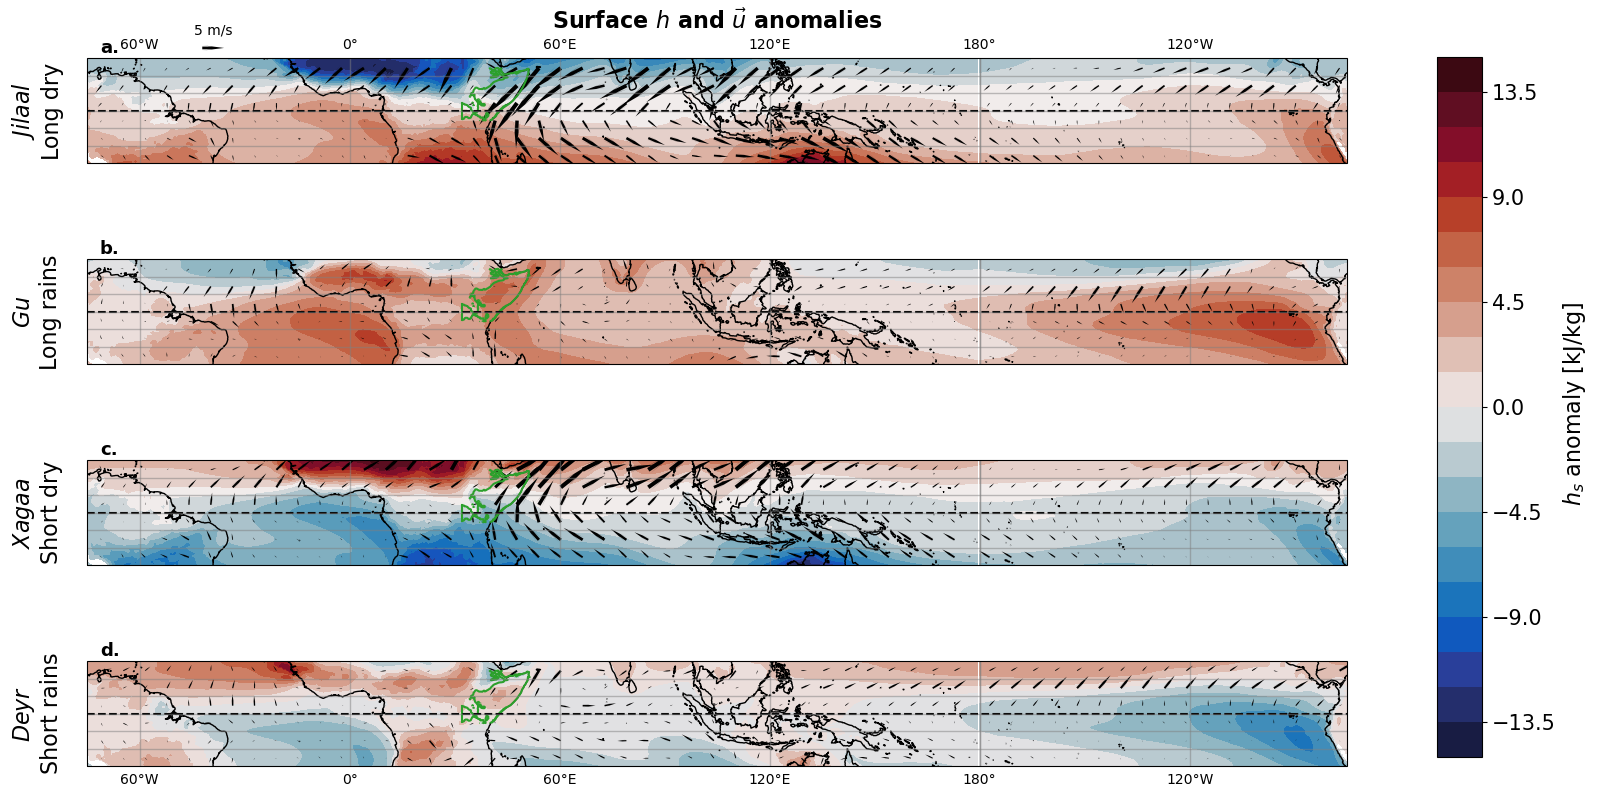

In [4]:
wrapper_figure1011(var='h-nsurf',
                 save_fig=True,output_fn=dir_list['figs']+'figure10')

/home/kschwarz/projects/gha_stability/figures/figure11.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure11.png saved!


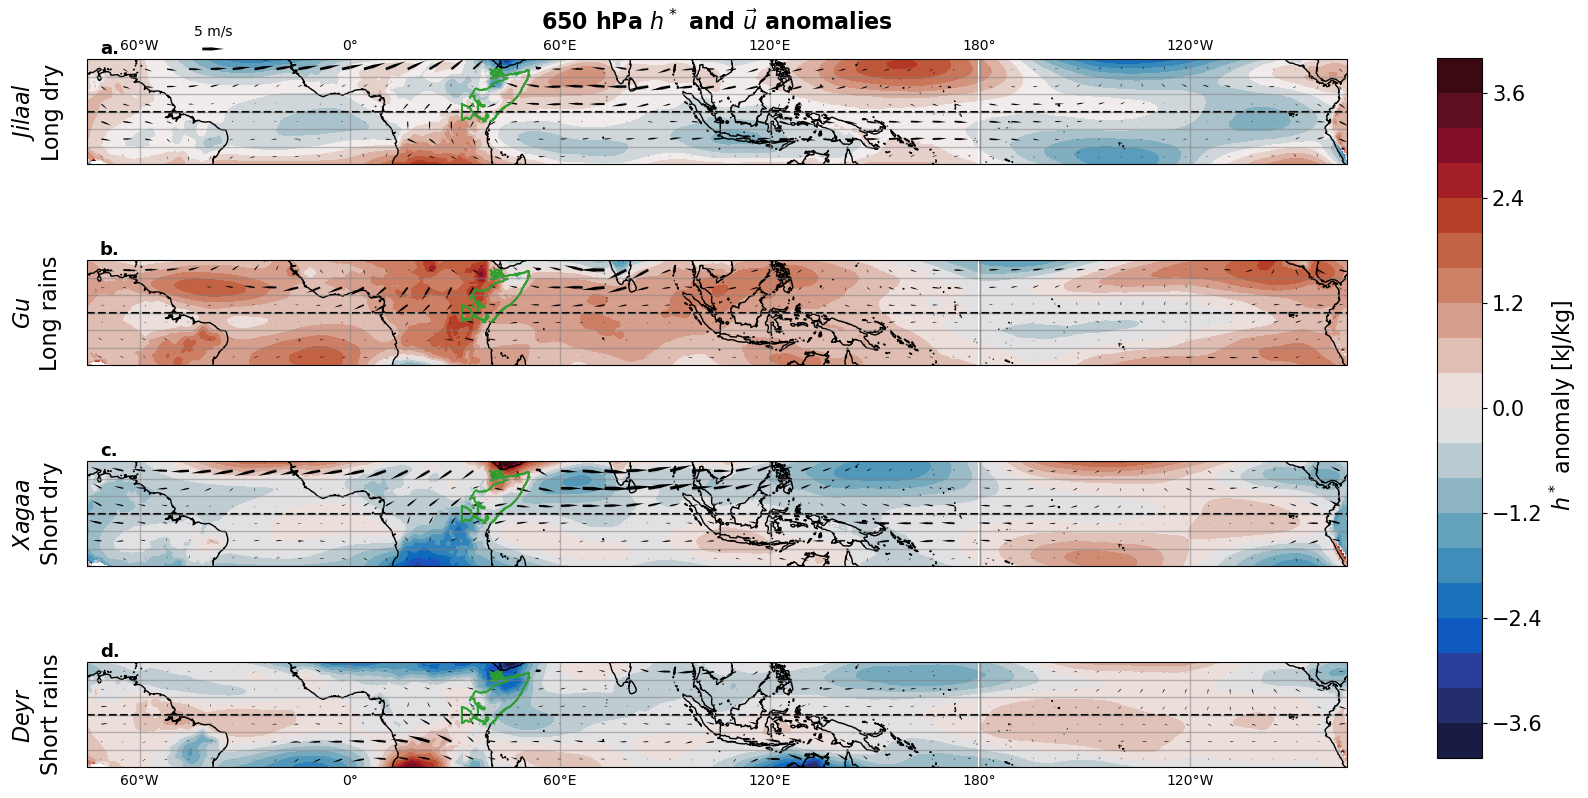

In [5]:
wrapper_figure1011(var='hsat',
                 save_fig=True,output_fn=dir_list['figs']+'figure11')

### Figure 12: interannual differences in $P$ vs. $h_s-h^*$

/home/kschwarz/projects/gha_stability/figures/figure12.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure12.png saved!


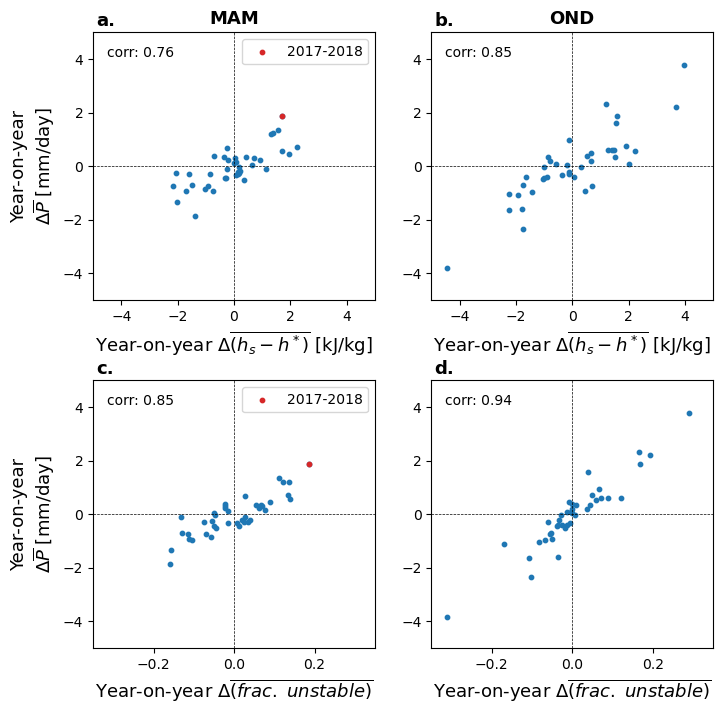

In [44]:
wrapper_figure12(save_fig=True,output_fn=dir_list['figs']+'figure12')

#### Alternate versions

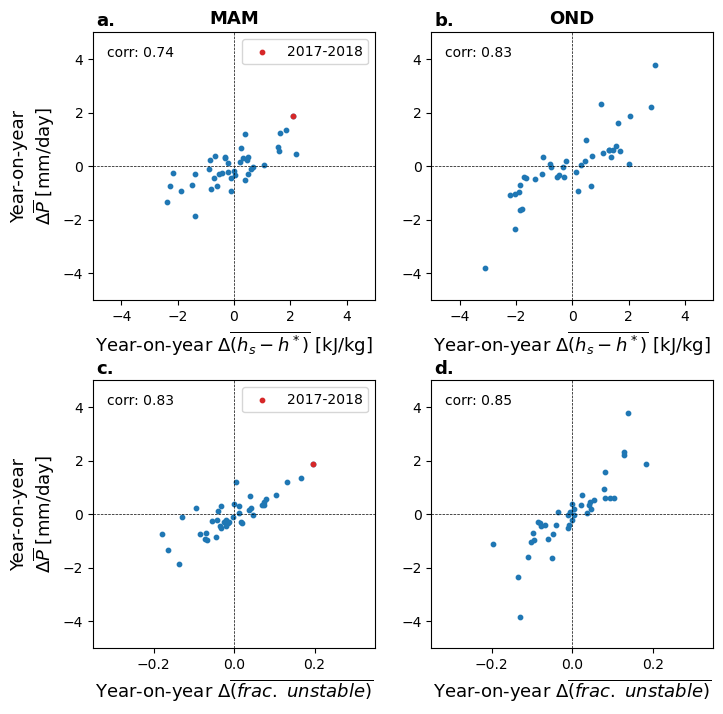

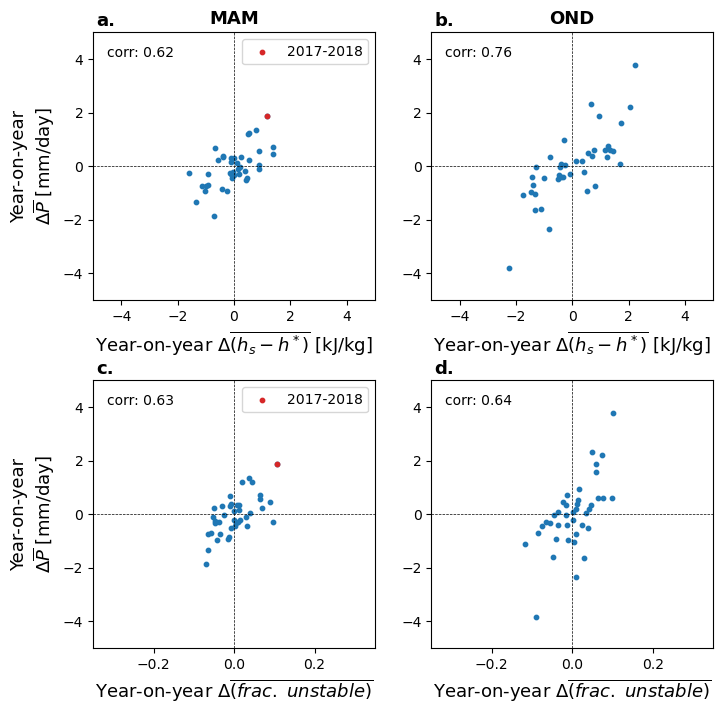

In [46]:
for mod in ['ERA5','JRA-55']:
    wrapper_figure12(mod_a=mod,save_fig=False)

### Figure 13: map differences in $P$, $h_s-h^*$

/home/kschwarz/projects/gha_stability/figures/figure13.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure13.png saved!


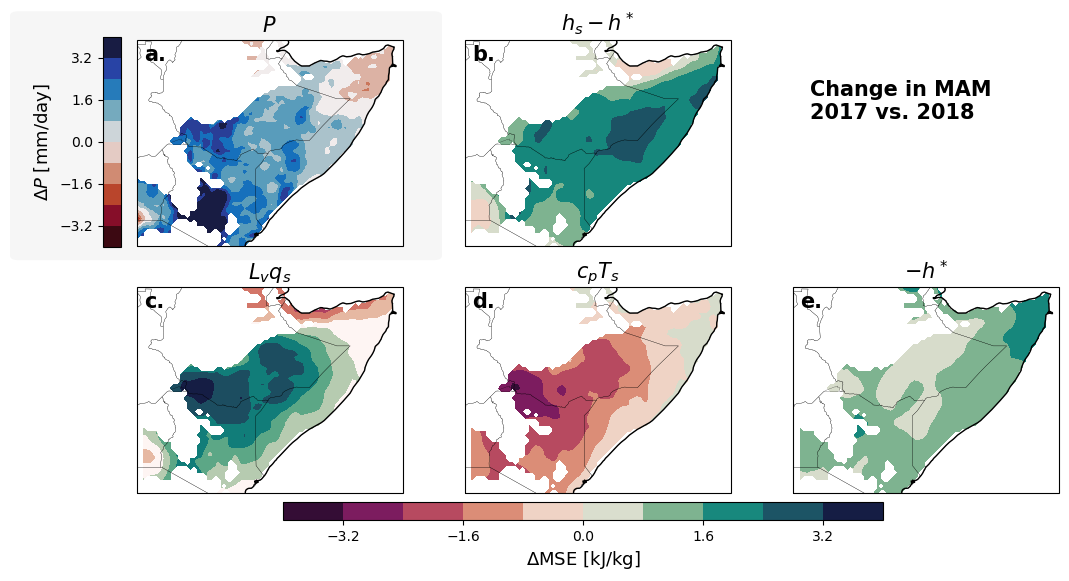

In [4]:
wrapper_figure13(mod_a='MERRA2',yrs=[[2017],[2018]],
                 save_fig=True,output_fn=dir_list['figs']+'figure13')

#### Alternate versions

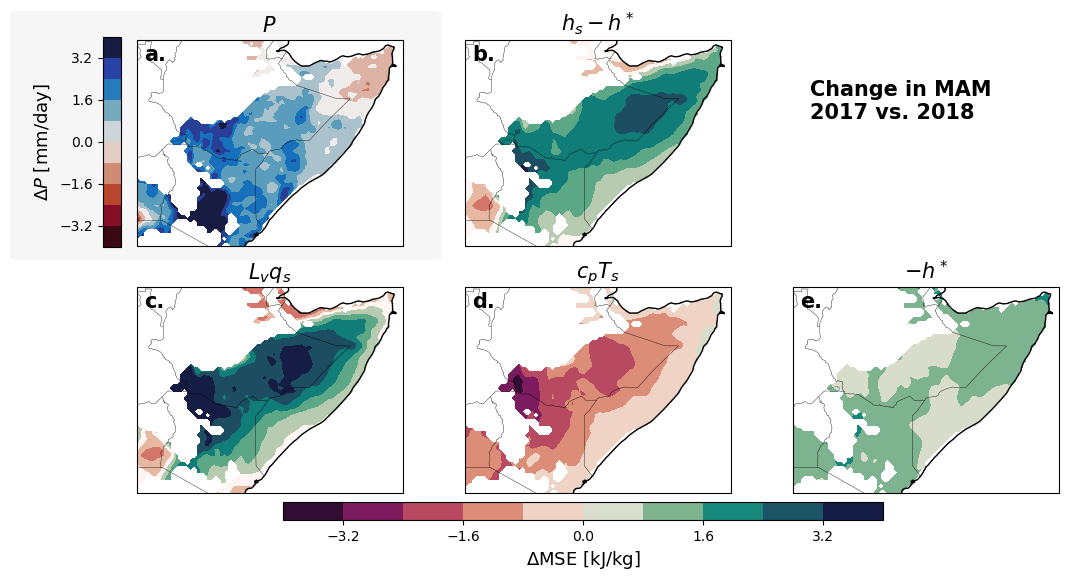

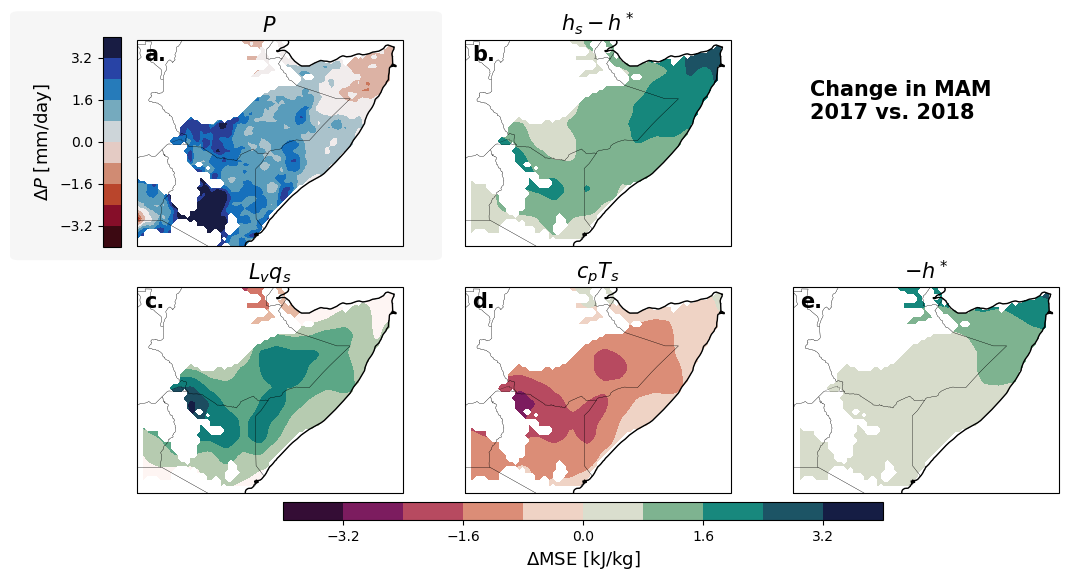

In [5]:
for mod in ['ERA5','JRA-55']:
    wrapper_figure13(mod_a=mod,save_fig=False)

### Figure S1: comparison between observational data products

../figures/figure_s1.pdf saved!
../figures/figure_s1.png saved!


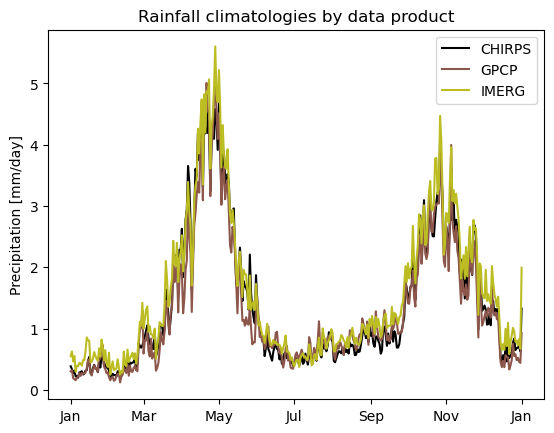

In [49]:
# See plot_figure_s1.py
%run plot_figure_s1.py

### Figure S2: vertical structure of $h_s-h^*$

../figures/figure_s2.pdf saved!
../figures/figure_s2.png saved!


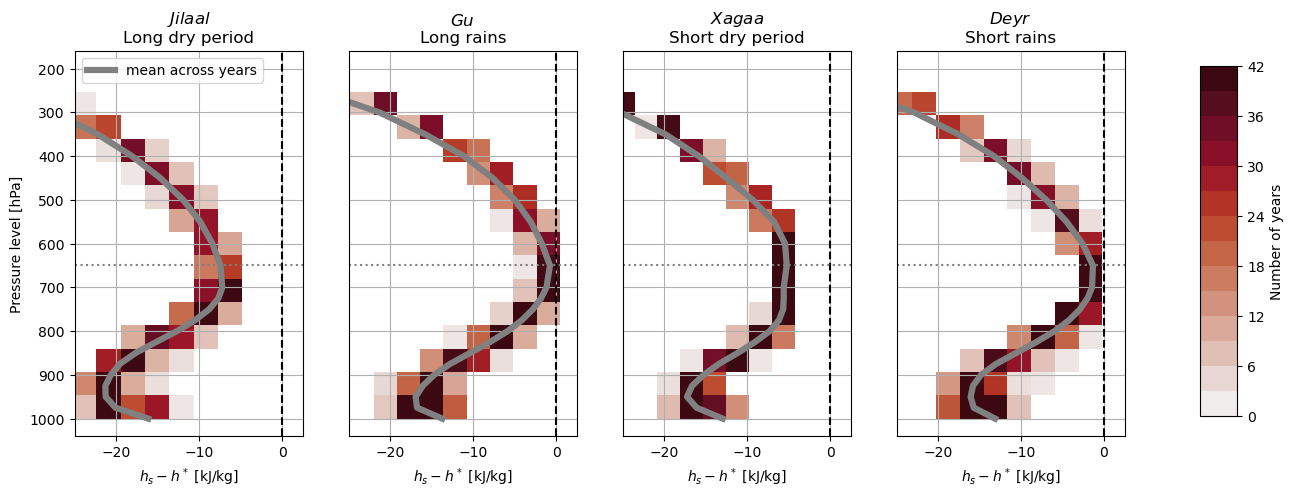

In [50]:
# See plot_figure_s2.py
%run plot_figure_s2.py

### Figure S3-4: comparison between reanalyses

../figures/figure_s3.pdf saved!
../figures/figure_s3.png saved!


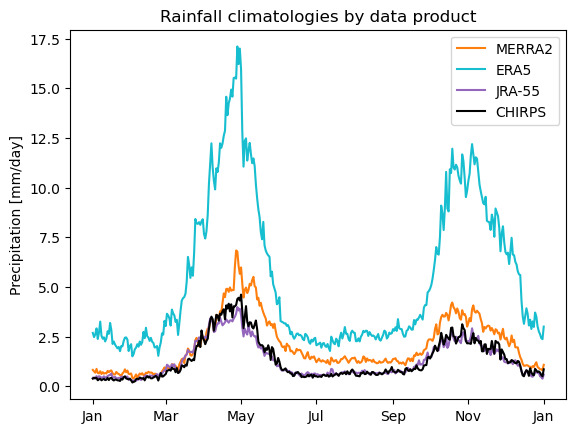

In [51]:
# See plot_figure_s3.py
%run plot_figure_s3.py

../figures/figure_s4.pdf saved!
../figures/figure_s4.png saved!


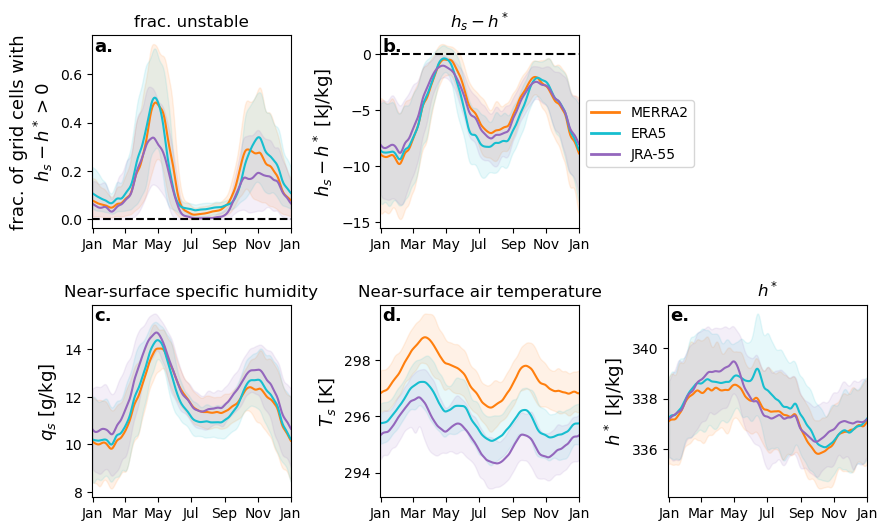

In [52]:
# See plot_figure_s4.py
%run plot_figure_s4.py

### Figure S7: Spatial correlations of daily $h_s-h^*$ 

/home/kschwarz/projects/gha_stability/figures/figure_s7.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure_s7.png saved!


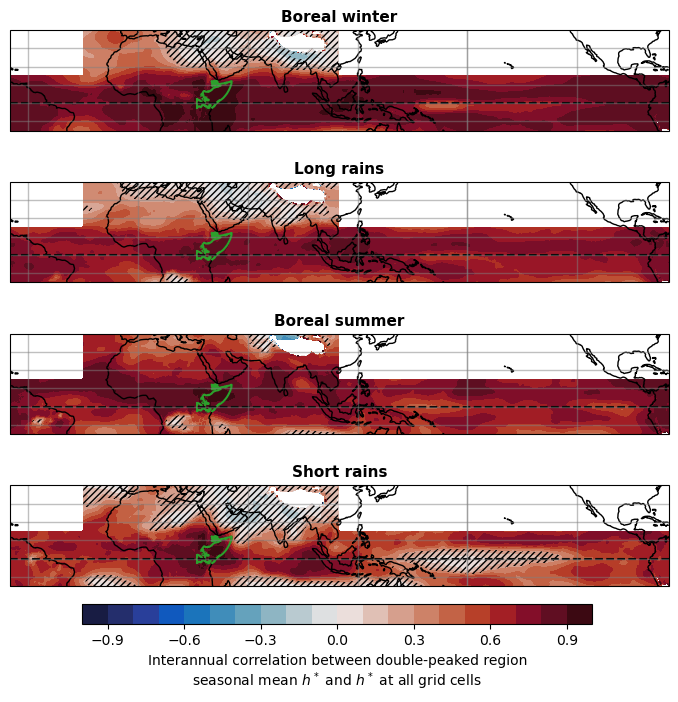

In [5]:
# See plot_figure_s7.py
%run plot_figure_s7.py

### Figure S8: Spatial correlations of seasonal $h_s-h^*$

/home/kschwarz/projects/gha_stability/code/funcs_load.py:162: UserWarning: Multiple files found, with no desired subset: 
  /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_day_MERRA2_historical_reanalysis_19810101-20211231_eq-IO.nc
  /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_day_MERRA2_historical_reanalysis_19810101-20211231_eq-Atl.nc
  /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_day_MERRA2_historical_reanalysis_19810101-20211231_eq-EPac.nc
  /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_day_MERRA2_historical_reanalysis_19810101-20211231_eq-WPac.nc
  warnings.warn('Multiple files found, with no '+
/home/kschwarz/projects/gha_stability/code/funcs_load.py:162: UserWarning: Multiple files found, with no desired subset: 
  /dx01/kschwarz/project_data/gha_stability/climate_proc/MERRA2/hsat_day_MERRA2_historical_reanalysis_19810101-20211231_subtrop-AfrSAsia.nc
  /dx01/kschwarz/project_data/gha_stability/c

/home/kschwarz/projects/gha_stability/figures/figure_s8.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure_s8.png saved!


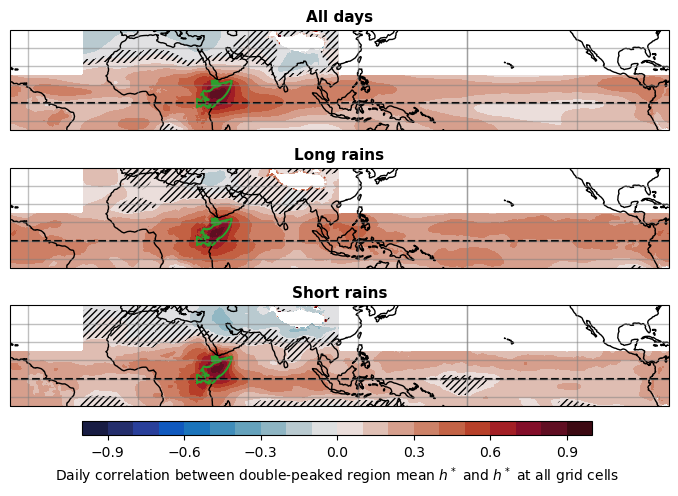

In [9]:
# See plot_figure_s8.py
%run plot_figure_s8.py

### Figure S9: Slopes of interannual changes across data products

/home/kschwarz/projects/gha_stability/figures/figure_s9.pdf saved!
/home/kschwarz/projects/gha_stability/figures/figure_s9.png saved!


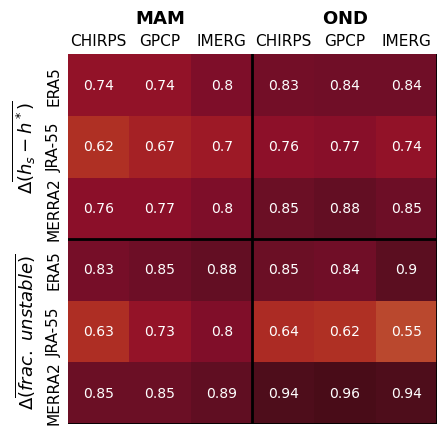

In [53]:
# See plot_figure_s9.py
%run plot_figure_s9.py